File: memory_test_1_VWW.txt
Total inferences: 1992
Correct Executions: 92.67%
Silent Data Corruptions percentage (SDCs): 6.93%
Silent Data Corruptions (SDCs): 138
  - Accuracy Shifts: 81.88%
  - Label Changes: 18.12%
Crashes: 1.51%
Crash count 30

File: memory_test_1_IC.txt
Total inferences: 2012
Correct Executions: 96.07%
Silent Data Corruptions percentage (SDCs): 3.78%
Silent Data Corruptions (SDCs): 76
  - Accuracy Shifts: 100.00%
  - Label Changes: 0.00%
Crashes: 0.30%
Crash count 6

File: memory_test_1_Motion.txt
Total inferences: 2061
Correct Executions: 99.76%
Silent Data Corruptions percentage (SDCs): 0.19%
Silent Data Corruptions (SDCs): 4
  - Accuracy Shifts: 100.00%
  - Label Changes: 0.00%
Crashes: 0.29%
Crash count 6



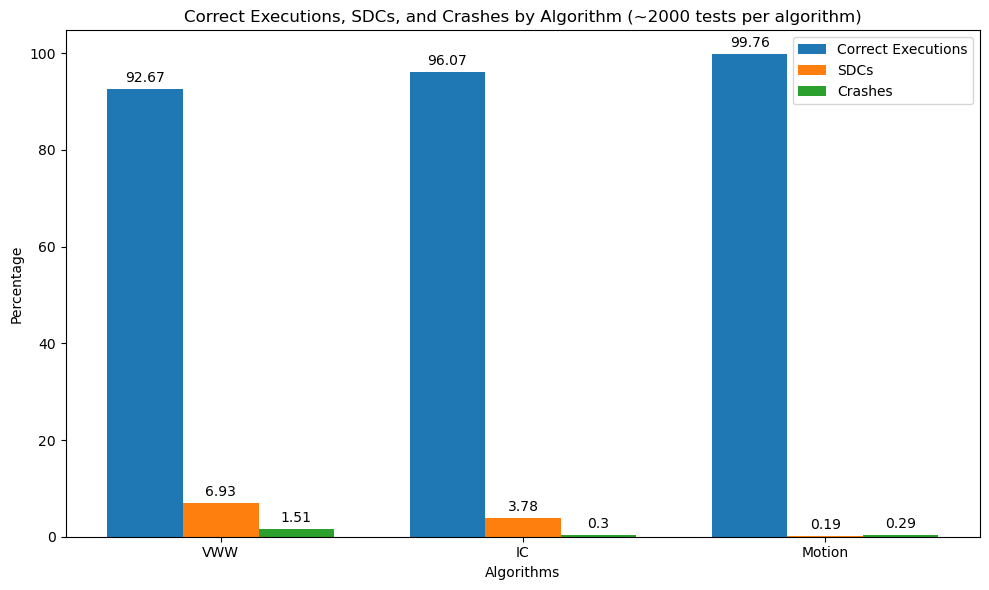

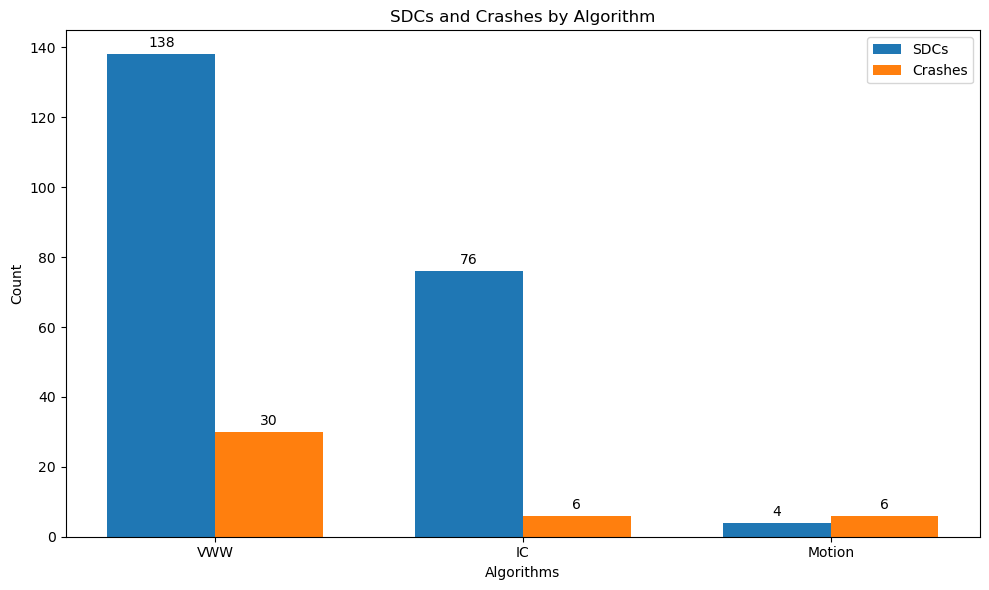

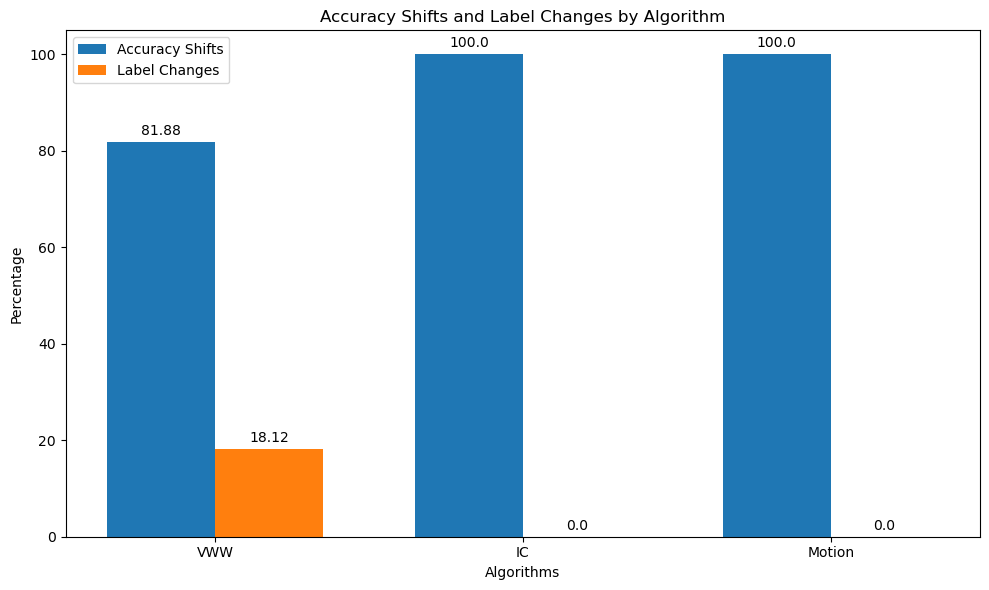

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

def analyze_fault_injections(file_path):
    unique_lists = defaultdict(int)
    bit_number_counts = defaultdict(int)
    crash_count = 0
    total_count = 0
    zero_output_count = 0
    accuracy_shifts = 0
    label_changes = 0

    with open(file_path, "r") as file:
        lines = file.readlines()

    for line in lines:
        if line.startswith("["):
            predictions = line.split("[")[1].split("]")[0]
            predictions_list = [float(item.strip()) for item in predictions.split(",")]
            
            if all(value == 0 for value in predictions_list):
                zero_output_count += 1
            else:
                unique_lists[tuple(predictions_list)] += 1
            total_count += 1

        elif line.startswith("Bit Number"):
            bit_number = int(line.split(":")[1].strip())
            bit_number_counts[bit_number] += 1

        elif "CRASH!" in line:
            crash_count += 1
        

    if not unique_lists:
        print("No valid output data found in the file.")
        return

    # Determine the most seen output (considered the correct output)
    correct_output, correct_count = max(unique_lists.items(), key=lambda item: item[1])

    # Analyze SDCs for accuracy shifts and label changes
    for predictions_list, count in unique_lists.items():
        if predictions_list != correct_output:
            if np.argmax(predictions_list) == np.argmax(correct_output):
                accuracy_shifts += count
            else:
                label_changes += count

    # Calculate percentages
    sdc_count = accuracy_shifts + label_changes
    sdc_percentage = (sdc_count / total_count) * 100
    crash_percentage = (crash_count / total_count) * 100
    correct_percentage = (correct_count / total_count) * 100

    if sdc_count > 0:
        accuracy_shift_percentage = (accuracy_shifts / sdc_count) * 100
        label_change_percentage = (label_changes / sdc_count) * 100
    else:
        accuracy_shift_percentage = 0
        label_change_percentage = 0

    print(f"File: {file_path}")
    print(f"Total inferences: {total_count}")
    print(f"Correct Executions: {correct_percentage:.2f}%")
    print(f"Silent Data Corruptions percentage (SDCs): {sdc_percentage:.2f}%")
    print(f"Silent Data Corruptions (SDCs): {sdc_count}")

    print(f"  - Accuracy Shifts: {accuracy_shift_percentage:.2f}%")
    print(f"  - Label Changes: {label_change_percentage:.2f}%")
    print(f"Crashes: {crash_percentage:.2f}%")
    print(f"Crash count {crash_count}\n")

    return {
        "total_inferences": total_count,
        "correct_percentage": correct_percentage,
        "sdc_percentage": sdc_percentage,
        "crash_percentage": crash_percentage,
        "accuracy_shift_percentage": accuracy_shift_percentage,
        "label_change_percentage": label_change_percentage,
        "accuracy_shifts": accuracy_shifts,
        "label_changes": label_changes,
        "crash_count": crash_count
    }

def plot_fault_injection_results(results, labels):
    # Prepare the data for plotting
    correct_perc = [result['correct_percentage'] for result in results]
    sdc_perc = [result['sdc_percentage'] for result in results]
    crash_perc = [result['crash_percentage'] for result in results]

    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    rects1 = ax.bar(x - width, correct_perc, width, label='Correct Executions')
    rects2 = ax.bar(x, sdc_perc, width, label='SDCs')
    rects3 = ax.bar(x + width, crash_perc, width, label='Crashes')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Algorithms')
    ax.set_ylabel('Percentage')
    ax.set_title('Correct Executions, SDCs, and Crashes by Algorithm (~2000 tests per algorithm)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Function to add labels above the bars
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    plt.show()

def plot_sdc_crash_counts(results, labels):
    # Prepare the data for plotting
    sdc_counts = [result['accuracy_shifts'] + result['label_changes'] for result in results]
    crash_counts = [result['crash_count'] for result in results]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    rects1 = ax.bar(x - width/2, sdc_counts, width, label='SDCs')
    rects2 = ax.bar(x + width/2, crash_counts, width, label='Crashes')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Algorithms')
    ax.set_ylabel('Count')
    ax.set_title('SDCs and Crashes by Algorithm')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Function to add labels above the bars
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

def plot_sdc_details(results, labels):
    # Prepare the data for plotting
    accuracy_shift_perc = [result['accuracy_shift_percentage'] for result in results]
    label_change_perc = [result['label_change_percentage'] for result in results]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    rects1 = ax.bar(x - width/2, accuracy_shift_perc, width, label='Accuracy Shifts')
    rects2 = ax.bar(x + width/2, label_change_perc, width, label='Label Changes')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Algorithms')
    ax.set_ylabel('Percentage')
    ax.set_title('Accuracy Shifts and Label Changes by Algorithm')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Function to add labels above the bars
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()
# Analyze the results for each algorithm
VWW_results = analyze_fault_injections("memory_test_1_VWW.txt")
IC_results = analyze_fault_injections("memory_test_1_IC.txt")
Motion_results = analyze_fault_injections("memory_test_1_Motion.txt")

# Store results and labels for plotting
results = [VWW_results, IC_results, Motion_results]
labels = ['VWW', 'IC', 'Motion']

# Plot the results
plot_fault_injection_results(results, labels)
plot_sdc_crash_counts(results, labels)
plot_sdc_details(results, labels)


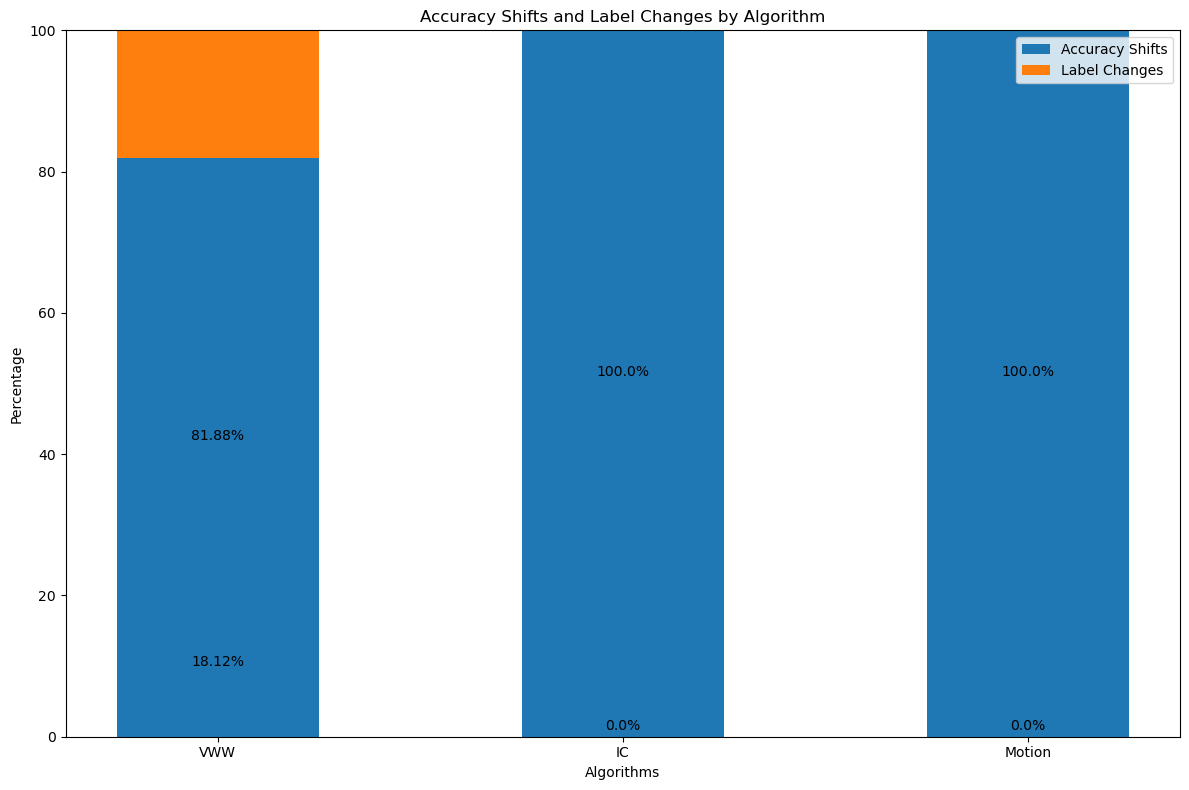

In [2]:
def plot_combined_sdc_details(results, labels):
    # Prepare the data for plotting
    accuracy_shift_perc = [result['accuracy_shift_percentage'] for result in results]
    label_change_perc = [result['label_change_percentage'] for result in results]

    x = np.arange(len(labels))  # the label locations
    width = 0.5  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 8))

    # Stacked bars for SDCs (Accuracy Shifts and Label Changes)
    rects1 = ax.bar(x, accuracy_shift_perc, width, label='Accuracy Shifts')
    rects2 = ax.bar(x, label_change_perc, width, bottom=accuracy_shift_perc, label='Label Changes')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Algorithms')
    ax.set_ylabel('Percentage')
    ax.set_title('Accuracy Shifts and Label Changes by Algorithm')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Function to add labels above the bars
    def autolabel(rects, heights):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect, height in zip(rects, heights):
            ax.annotate(f'{round(height, 2)}%',
                        xy=(rect.get_x() + rect.get_width() / 2, height/2),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1, accuracy_shift_perc)
    autolabel(rects2, label_change_perc)

    fig.tight_layout()
    plt.show()
# Plot the combined results
plot_combined_sdc_details(results, labels)
